In [1]:
!pip install flask

In [2]:
!pip install scikit-learn

In [3]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Считываем все файлы с диалогами из датасета

In [4]:
import pandas as pd
import glob

# Чтение всех CSV-файлов с диалогами
all_files = glob.glob("/content/drive/MyDrive/MFTI/NLP/HouseMD/*.csv")
df_list = [pd.read_csv(f, encoding='utf-8', encoding_errors='replace') for f in all_files]
df = pd.concat(df_list, ignore_index=True)

print(df.columns)
print(df.head(5))
print(f"Total lines: {len(df)}")


Index(['name', 'line'], dtype='object')
      name                                               line
0    House                              Pericardial effusion.
1     Taub   Which wasn't there last night when we did the...
2  Foreman   She's getting worse, and there's no sign of a...
3    Chase                                 Or maybe a cancer.
4  Foreman   We could use your opinion, House, or at least...
Total lines: 75312


Далее работаем только с репликами Грегори Хауса

In [5]:
house_lines = df[df['name'] == 'House'].copy()
print(house_lines.shape)
print(house_lines['line'].iloc[:5])

(20908, 2)
0                                 Pericardial effusion.
5      (taking off his glasses and looking up at the...
7      She was gonna kill herself. This is the final...
9          Yeah. I know why she wanted to kill herself.
10     His mentor, Helen Rutherford, has contracted ...
Name: line, dtype: object


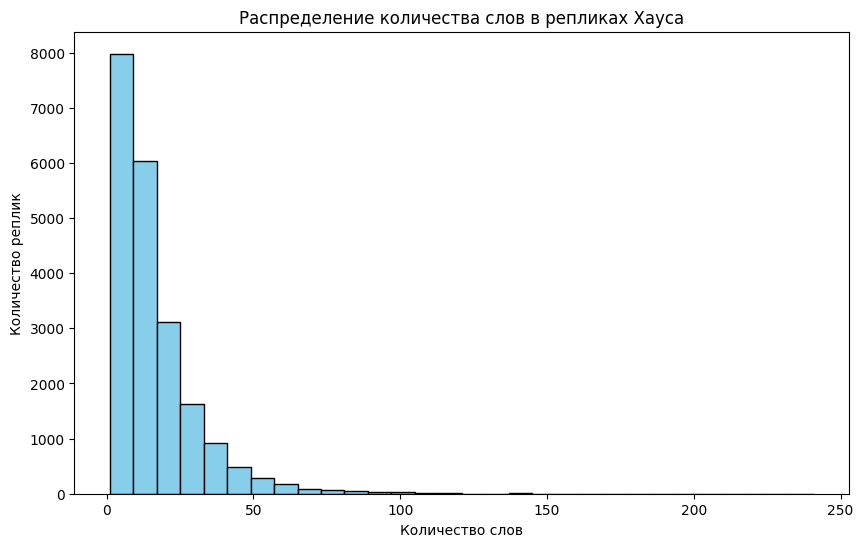

In [6]:
path_to_graphs = "/content/drive/MyDrive/MFTI/NLP/HW1/graphs"
import matplotlib.pyplot as plt

# Добавляем колонку с количеством слов в каждой реплике
house_lines['word_count'] = house_lines['line'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
plt.hist(house_lines['word_count'], bins=30, color='skyblue', edgecolor='black')
plt.title("Распределение количества слов в репликах Хауса")
plt.xlabel("Количество слов")
plt.ylabel("Количество реплик")
plt.savefig(f"{path_to_graphs}/word_count_distribution.png")  # сохраняем график
plt.show()

Проводим предподготовку текста. Приводим текст к нижниму регистру, удаляем все кроме букв, токинизируем и удалем стоп слова по шаблону ntlk. Лемматизация не првела к удовлетворительному результату. В опытах со стеммингом результат приемлемый.

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Скачиваем необходимые данные NLTK (выполняется один раз)
nltk.download('punkt', force=True)
nltk.download('wordnet', force=True)
nltk.download('stopwords', force=True)
nltk.download('punkt_tab')
stemmer = PorterStemmer()

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text: str) -> str:
    """
    Функция для предобработки текста:
    - приведение к нижнему регистру,
    - удаление символов, отличных от букв,
    - токенизация,
    - удаление стоп-слов,
    - лемматизация.
    - Стемминг
    """
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление всего, кроме букв и пробелов
    text = re.sub(r'[^a-z\s]', '', text)
    # Токенизация
    tokens = word_tokenize(text)
    # Удаление стоп-слов
    tokens = [word for word in tokens if word not in stop_words]
    # Лемматизация
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Стемминг
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    # Объединение обратно в строку
    return ' '.join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [8]:
# house_lines['line'] – список исходных реплик
house_lines['Dialogue_processed'] = house_lines['line'].apply(preprocess_text)

Удаляем редки слова. Все слова которые встречаются резе чем 3х раз удаляются из корпуса

In [9]:
from collections import Counter

# Подсчет встречаемости слов в корпусе
word_counts = Counter(' '.join(house_lines['Dialogue_processed']).split())

# Убираем редкие слова (например, те, что встречаются <3 раз)
def remove_rare_words(text):
    return ' '.join([word for word in text.split() if word_counts[word] > 2])

house_lines['Dialogue_processed'] = house_lines['Dialogue_processed'].apply(remove_rare_words)


Проводим векторизацию текста с помощью TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2))
# Обучаем векторизатор на всех репликах Доктора Dialogue_processed
tfidf_matrix = vectorizer.fit_transform(house_lines['Dialogue_processed'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

TF-IDF matrix shape: (20908, 109498)


Переводим запрос TF-IDF вектор и вычисляем косинусовое сходство вектора запроса и всеми векторами реплик Грегори Хауса

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

def find_best_reply(query_en: str) -> str:
    processed_query = preprocess_text(query_en)
    # Преобразуем запрос в TF-IDF
    query_vec = vectorizer.transform([processed_query])
    # Считаем косинусное сходство с каждой репликой (результат - массив значений)
    similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()
    # Индекс наиболее похожей реплики
    best_index = similarities.argmax()
    best_reply_en = house_lines['line'].iloc[best_index]
    return best_reply_en

# Пример поиска ответа на английский запрос
sample_query = "who lies?"  # пример запроса пользователя (англ.)
best_en = find_best_reply(sample_query)
print("Best match (EN):", best_en)


Best match (EN):  Everybody lies.


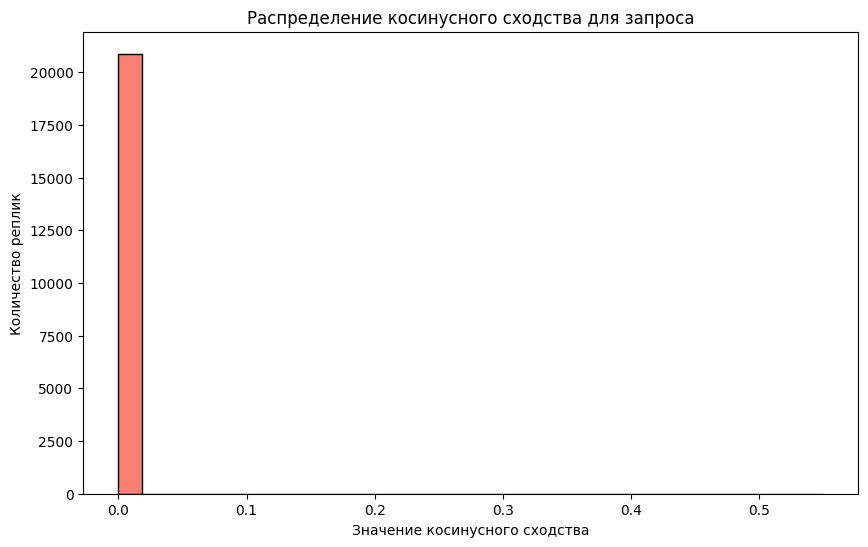

In [25]:
query = "Who lies?"
processed_query = preprocess_text(query)
query_vec = vectorizer.transform([processed_query])
similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()

plt.figure(figsize=(10,6))
plt.hist(similarities, bins=30, color='salmon', edgecolor='black')
plt.title("Распределение косинусного сходства для запроса")
plt.xlabel("Значение косинусного сходства")
plt.ylabel("Количество реплик")
plt.savefig(f'{path_to_graphs}/{query}.png')
plt.show()

Используем SentenceTransformer для эмбедингов предложений

In [19]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(house_lines['Dialogue_processed'].tolist(), convert_to_tensor=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Проведем косинусовое сравнение семантически преобразованных эмбедингов запроса и реплик Грегори

In [20]:
def find_best_reply_semantic(query_en: str) -> str:
    processed_query = preprocess_text(query_en)
    query_emb = model.encode(processed_query, convert_to_tensor=True)
    # Считаем косинусные схожести и находим индекс максимального
    cos_scores = util.cos_sim(query_emb, embeddings)[0]
    best_index = int(cos_scores.argmax())
    return house_lines['line'].iloc[best_index]

# Пример семантического поиска
sample_query = "who lies?"  # пример запроса пользователя (англ.)  who lies?
best_en_sem = find_best_reply_semantic(sample_query)
print("Best semantic match (EN):", best_en_sem)
best_en = find_best_reply(sample_query)
print("Best match (EN):", best_en)

Best semantic match (EN):  You lied to me.
Best match (EN):  Everybody lies.


Построим гистограмму для сравнения косинусового сходства подхода простого TF-IDF и нейросетевой модели семантического сходства

<ipython-input-33-94ac2b000c66>:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["TF-IDF", "Neural"])


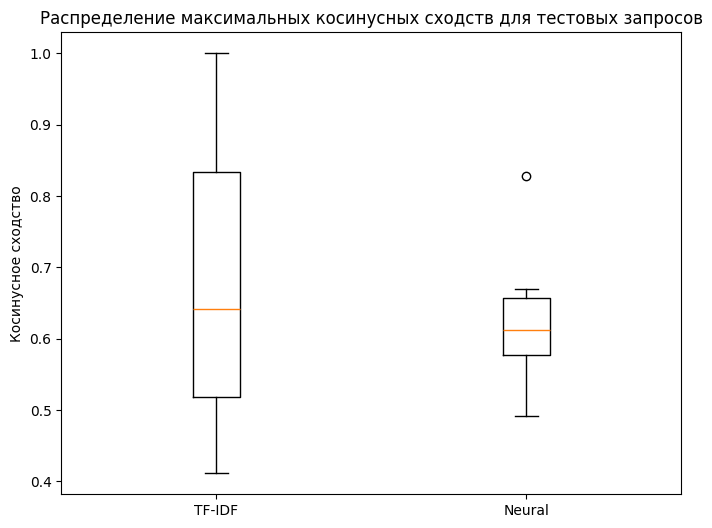

In [33]:
test_queries = [
    "Who lies?",
    "Are all people honest?",
    "What is your diagnosis?",
    "Tell me something witty.",
    "How do you feel about life?",
    "Explain your process."
]

tfidf_similarities = []
neural_similarities = []

for query in test_queries:
    # TF-IDF
    processed_query = preprocess_text(query)
    query_vec = vectorizer.transform([processed_query])
    sim_tfidf = cosine_similarity(query_vec, tfidf_matrix).flatten().max()
    tfidf_similarities.append(sim_tfidf)

    # Для нейросетевой модели
    query_embedding = model.encode(query, convert_to_tensor=True)
    cosine_scores = util.cos_sim(query_embedding, embeddings)[0]
    sim_neural = cosine_scores.max().item()
    neural_similarities.append(sim_neural)

# Построим гистограмму
data = [tfidf_similarities, neural_similarities]
plt.figure(figsize=(8,6))
plt.boxplot(data, labels=["TF-IDF", "Neural"])
plt.title("Распределение максимальных косинусных сходств для тестовых запросов")
plt.ylabel("Косинусное сходство")
plt.savefig(f"{path_to_graphs}/similarity_comparison_boxplot.png")
plt.show()

Вывод. Простое использование сравнений по косинусу векторов TF-IDF выглядит приемлемие чем использование предобученной модели и сравнение косинусов эмбедингов. Но графики показывают, что TF-IDF дает больший разброс по схожести косинусов, но при этом в оедких случаях может дать точно такой же ответ как и Доктор Хаус.
Модель all-MiniLM-L6-v2 показывет более предсказуемый результат. Но ответы "дальше" по косинусу от реплик который мог бы сказать Доктор Хаус. В этом кроется причина, почему на мой субективный взгляд, семантическая не может дать мне ответ, который я на 100% ожидаю услышать от Доктора Хауса